# XGBoost Regressor


In [1]:
import sys
!{sys.executable} -m pip install xgboost

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor, plot_importance

# 1. Učitavanje podataka
df = pd.read_csv("sales_data2.csv")  # tvoj novi CSV s dodatnim featureima

# 2. Definicija X i y
X = df.drop(columns=['Sales_Amount'])
y = np.log1p(df['Sales_Amount'])  # log transformacija targeta

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Kategorikalni i numerički atributi
categorical = ['Sales_Rep', 'Region', 'Product_Category', 'Customer_Type', 'Payment_Method']
numerical = [col for col in X.columns if col not in categorical]

# 5. Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical)
], remainder='passthrough')

# 6. XGBoost pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42))
])

# 7. Treniranje modela
model.fit(X_train, y_train)

# 8. Predikcija
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # vraćanje na originalnu skalu
y_test_actual = np.expm1(y_test)

# 9. Evaluacija
print("📊 Evaluacija XGBoost modela:")
print("MAE:", round(mean_absolute_error(y_test_actual, y_pred), 2))
print("MSE:", round(mean_squared_error(y_test_actual, y_pred), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test_actual, y_pred)), 2))
print("R² Score:", round(r2_score(y_test_actual, y_pred), 4))



📊 Evaluacija XGBoost modela:
MAE: 2624.8
MSE: 10516635.86
RMSE: 3242.94
R² Score: -0.3375


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

# 📥 Učitavanje podataka
df = pd.read_csv("sales_data2.csv")

# ➕ Dodatni featurei
df['Price_to_Cost_Ratio'] = df['Unit_Price'] / df['Unit_Cost']
df['Revenue_per_Unit'] = df['Sales_Amount'] / df['Quantity_Sold']
df['Has_Discount'] = (df['Discount'] > 0).astype(int)

# 🎯 Target
y = np.log1p(df['Sales_Amount'])
X = df.drop(columns=['Sales_Amount'])

# 🔠 Kategorije i numeričke varijable
categorical = ['Sales_Rep', 'Region', 'Product_Category', 'Customer_Type', 'Payment_Method']
numerical = [col for col in X.columns if col not in categorical]



# 🧼 Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), categorical),
    ('num', StandardScaler(), numerical)
])

# 🔄 Transformacija
X_prepared = preprocessor.fit_transform(X)

# 📊 Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.2, random_state=42)

# 📦 Konverzija u DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# ⚙️ Parametri modela
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# 🚀 Treniranje s early stopping
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=[(dtest, 'eval')],
    early_stopping_rounds=20,
    verbose_eval=False
)

# 📈 Predikcija
y_pred_log = model.predict(dtest)
y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

# 🧪 Evaluacija
print("📊 Results:")
print("MAE:", round(mean_absolute_error(y_test_original, y_pred), 2))
print("MSE:", round(mean_squared_error(y_test_original, y_pred), 2))
print("RMSE:", round(mean_squared_error(y_test_original, y_pred, squared=False), 2))
print("R² Score:", round(r2_score(y_test_original, y_pred), 4))


📊 Results:
MAE: 566.94
MSE: 818520.26
RMSE: 904.72
R² Score: 0.8959


FEATURE IMPORTANCE 
~ analyzing which factors affect the model the most

<Figure size 1200x800 with 0 Axes>

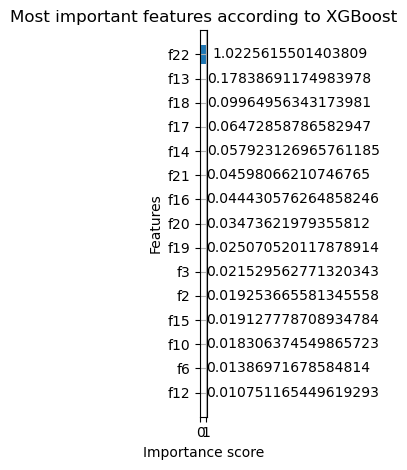

In [5]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(12, 8))
plot_importance(model, max_num_features=15, importance_type='gain', height=0.8)
plt.title("Most important features according to XGBoost")
plt.grid(True)
plt.tight_layout()
plt.show()


Better code below:

📊 Results:
MAE: 566.94
MSE: 818520.26
RMSE: 904.72
R² Score: 0.8959


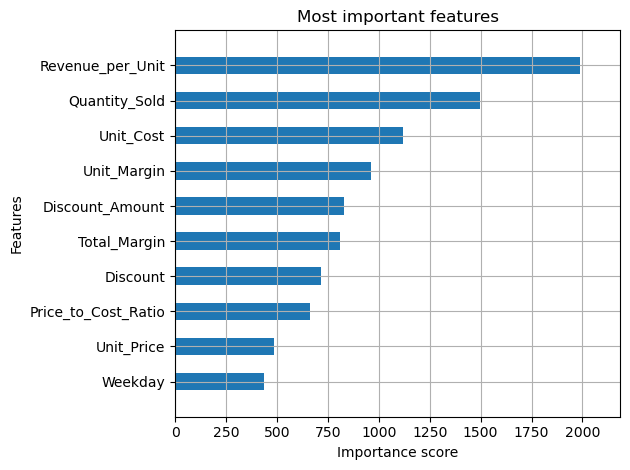

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

# 📥 1. Učitavanje podataka
df = pd.read_csv("sales_data2.csv")

# ➕ 2. Dodavanje dodatnih featurea
df['Price_to_Cost_Ratio'] = df['Unit_Price'] / df['Unit_Cost']
df['Revenue_per_Unit'] = df['Sales_Amount'] / df['Quantity_Sold']
df['Has_Discount'] = (df['Discount'] > 0).astype(int)

# 🎯 3. Definicija targeta i inputa
y = np.log1p(df['Sales_Amount'])  # log-transformacija targeta
X = df.drop(columns=['Sales_Amount'])

# 🔠 4. Kategorije i numeričke varijable
categorical = ['Sales_Rep', 'Region', 'Product_Category', 'Customer_Type', 'Payment_Method']
numerical = [col for col in X.columns if col not in categorical]

# 🧼 5. Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), categorical),
    ('num', StandardScaler(), numerical)
])

# 🔄 6. Primjena transformacije
X_prepared = preprocessor.fit_transform(X)

# ✅ 7. Dohvaćanje imena featurea nakon transformacije
ohe = preprocessor.named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical)
feature_names = list(ohe_feature_names) + numerical

# 📊 8. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.2, random_state=42)

# 📦 9. Konverzija u DMatrix za XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=feature_names)

# ⚙️ 10. Parametri modela
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# 🚀 11. Treniranje s early stoppingom
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=[(dtest, 'eval')],
    early_stopping_rounds=20,
    verbose_eval=False
)

# 📈 12. Predikcija
y_pred_log = model.predict(dtest)
y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

# 🧪 13. Evaluacija
print("📊 Results:")
print("MAE:", round(mean_absolute_error(y_test_original, y_pred), 2))
print("MSE:", round(mean_squared_error(y_test_original, y_pred), 2))
print("RMSE:", round(mean_squared_error(y_test_original, y_pred, squared=False), 2))
print("R² Score:", round(r2_score(y_test_original, y_pred), 4))

# 📊 14. Važnost featurea (opcionalno)
import matplotlib.pyplot as plt
xgb.plot_importance(model, max_num_features=10, height=0.5, show_values=False)
plt.title("Most important features")
plt.tight_layout()
plt.show()


SHAP ANALYSIS

In [13]:
pip install shap

   ---------------------------------------- 0.0/544.4 kB ? eta -:--:--
    --------------------------------------- 10.2/544.4 kB ? eta -:--:--
   -- ------------------------------------ 41.0/544.4 kB 487.6 kB/s eta 0:00:02
   --------- ------------------------------ 122.9/544.4 kB 1.0 MB/s eta 0:00:01
   ------------------ --------------------- 256.0/544.4 kB 1.6 MB/s eta 0:00:01
   ------------------------------ --------- 409.6/544.4 kB 1.8 MB/s eta 0:00:01
   ---------------------------------- ----- 471.0/544.4 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------  542.7/544.4 kB 1.9 MB/s eta 0:00:01
   ---------------------------------------- 544.4/544.4 kB 1.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


📊 Rezultati:
MAE: 566.94
MSE: 818520.26
RMSE: 904.72
R² Score: 0.8959


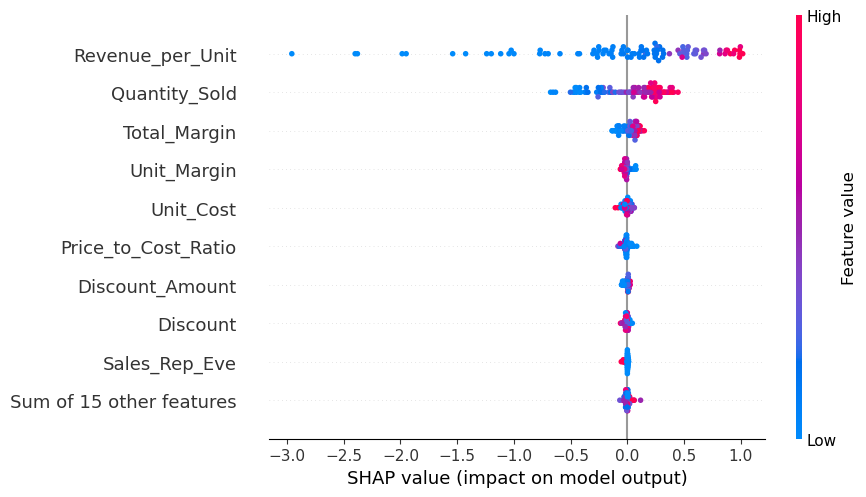

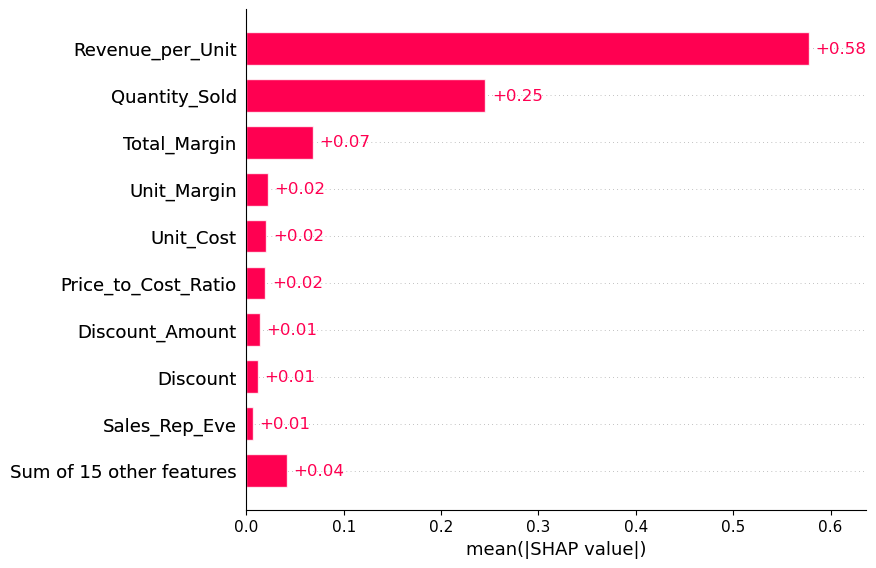

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

# 📥 Učitavanje podataka
df = pd.read_csv("sales_data2.csv")

# ➕ Dodatni featurei
df['Price_to_Cost_Ratio'] = df['Unit_Price'] / df['Unit_Cost']
df['Revenue_per_Unit'] = df['Sales_Amount'] / df['Quantity_Sold']
df['Has_Discount'] = (df['Discount'] > 0).astype(int)

# 🎯 Target
y = np.log1p(df['Sales_Amount'])
X = df.drop(columns=['Sales_Amount'])

# 🔠 Kategorije i numeričke varijable
categorical = ['Sales_Rep', 'Region', 'Product_Category', 'Customer_Type', 'Payment_Method']
numerical = [col for col in X.columns if col not in categorical]

# 🧼 Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), categorical),
    ('num', StandardScaler(), numerical)
])

# 🔄 Transformacija
X_prepared = preprocessor.fit_transform(X)

# 🔠 Rekonstrukcija imena kolona nakon transformacije
# 1. Dobij one-hot encoded nazive
ohe = preprocessor.named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical)

# 2. Spoji sve nazive: one-hot + numeričke
all_feature_names = list(ohe_feature_names) + numerical


# 📊 Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.2, random_state=42)

# 📦 Konverzija u DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# ⚙️ Parametri modela
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# 🚀 Treniranje s early stopping
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=[(dtest, 'eval')],
    early_stopping_rounds=20,
    verbose_eval=False
)

# 📈 Predikcija
y_pred_log = model.predict(dtest)
y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

# 🧪 Evaluacija
print("📊 Rezultati:")
print("MAE:", round(mean_absolute_error(y_test_original, y_pred), 2))
print("MSE:", round(mean_squared_error(y_test_original, y_pred), 2))
print("RMSE:", round(mean_squared_error(y_test_original, y_pred, squared=False), 2))
print("R² Score:", round(r2_score(y_test_original, y_pred), 4))

# ------------------------------------------
# 🧠 SHAP analiza važnosti featurea
# ------------------------------------------

explainer = shap.Explainer(model, feature_names=all_feature_names)
shap_values = explainer(dtest)

# Prikaz grafova
shap.initjs()

# 🌈 Beeswarm (detaljan prikaz svih featurea)
shap.plots.beeswarm(shap_values)

# 📊 Bar plot (osnovna važnost featurea)
shap.plots.bar(shap_values)


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488 entries, 0 to 487
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Sales_Rep            488 non-null    object 
 1   Region               488 non-null    object 
 2   Sales_Amount         488 non-null    float64
 3   Quantity_Sold        488 non-null    int64  
 4   Product_Category     488 non-null    object 
 5   Unit_Cost            488 non-null    float64
 6   Unit_Price           488 non-null    float64
 7   Customer_Type        488 non-null    object 
 8   Discount             488 non-null    float64
 9   Payment_Method       488 non-null    object 
 10  Unit_Margin          488 non-null    float64
 11  Total_Margin         488 non-null    float64
 12  Discount_Amount      488 non-null    float64
 13  Weekday              488 non-null    int64  
 14  Price_to_Cost_Ratio  488 non-null    float64
 15  Revenue_per_Unit     488 non-null    flo